# deCIFer: Loss Curve Visualization  

- Plots training and validation loss curves from multiple experiments  
- Displays minimum validation loss with annotations  
- Shows trends over epochs for model performance tracking  
- Saves figures for analysis and comparison  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from decifer.utility import get_metrics
from bin.train import TrainConfig

import warnings
warnings.simplefilter("ignore")

def plot_loss_curves(paths, ylog=True, xlog=False, xmin=None, xmax=None, ymin=None, ymax=None, offset=0.02, plot_metrics=True, figsize=(10, 5), 
                     custom_legend_labels=None, train_linewidth=2, val_linewidth=2, font_config=None, save_figure_path=None):
    """
    Plots training and validation loss curves from multiple paths with custom options.

    Args:
        paths (list): List of paths to metrics files or data.
        ylog (bool): Whether to use a logarithmic scale for the y-axis.
        xlog (bool): Whether to use a logarithmic scale for the x-axis.
        xmin, xmax (float): Limits for the x-axis.
        ymin, ymax (float): Limits for the y-axis.
        offset (float): Offset to avoid overlapping text annotations.
        plot_metrics (bool): Whether to include additional metrics.
        figsize (tuple): Size of the figure.
        custom_legend_labels (list): Custom labels for legend entries, must match `paths`.
        train_linewidth (float): Line width for training loss curves.
        val_linewidth (float): Line width for validation loss curves.
        font_config (dict): Custom font configuration for the plot.
        save_figure_path (str): Path to save the figure as a file.

    Returns:
        None
    """
    if font_config is None:
        font_config = {
            "font.size": 12,
            "axes.titlesize": 14,
            "axes.labelsize": 14,
            "xtick.labelsize": 10,
            "ytick.labelsize": 14,
            "legend.fontsize": 14,
        }
    plt.rcParams.update(font_config)

    sns.set_theme(style="whitegrid")
    fig, ax_loss = plt.subplots(figsize=figsize, dpi=150)
    text_positions = []

    ax_loss.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')

    if xmin is not None or xmax is not None:
        ax_loss.set_xlim(xmin, xmax)
    if ymin is not None or ymax is not None:
        ax_loss.set_ylim(ymin, ymax)
    if ylog:
        ax_loss.set_yscale('log')
    if xlog:
        ax_loss.set_xscale('log')

    ax_loss.grid(alpha=0.4, which="both")

    for i, path in enumerate(paths):
        metrics, fname = get_metrics(path)
        legend_fname = '/'.join(fname.split("/")[-2:])

        legend_label_train = custom_legend_labels[i] + " [Train]" if custom_legend_labels else f'{legend_fname} [Train]'
        legend_label_val = custom_legend_labels[i] + " [Validation]" if custom_legend_labels else f'{legend_fname} [Validation]'
        
        losses_train = np.array(metrics['train_losses'])
        losses_val = np.array(metrics['val_losses'])
        
        try:
            epochs = np.array(metrics['epoch_losses'])
        except KeyError:
            epochs = np.array(metrics['epochs'])
        
        p = sns.lineplot(x=epochs, y=losses_train, label=legend_label_train, ax=ax_loss, linewidth=train_linewidth)
        sns.lineplot(x=epochs, y=losses_val, label=legend_label_val, ax=ax_loss, linewidth=val_linewidth, linestyle='--', color=p.get_lines()[-1].get_color())
        
        try:
            val_line_min = epochs[np.argmin(losses_val)]
            min_loss_val = np.min(losses_val)
            ax_loss.plot([val_line_min, ax_loss.get_xlim()[1]], [min_loss_val, min_loss_val],
                         c=p.get_lines()[-1].get_color(), ls=':', alpha=1.0)

            text_x = ax_loss.get_xlim()[1]
            text_y = min_loss_val
            vert_align = 'bottom'
            for pos in text_positions:
                if abs(pos[1] - text_y) < offset:
                    vert_align = 'top'

            ax_loss.text(text_x, text_y, f'{min_loss_val:.4f}', 
                         verticalalignment=vert_align, horizontalalignment='right', color=p.get_lines()[-1].get_color(),
                         fontsize=10)
            text_positions.append((text_x, text_y))
        except Exception as e:
            print(f"Error plotting validation loss for {legend_fname}: {e}")
    
    ax_loss.legend()
    fig.tight_layout()
    plt.show()
    if save_figure_path is not None:
        fig.savefig(save_figure_path, transparent=True, bbox_inches='tight', dpi=300)


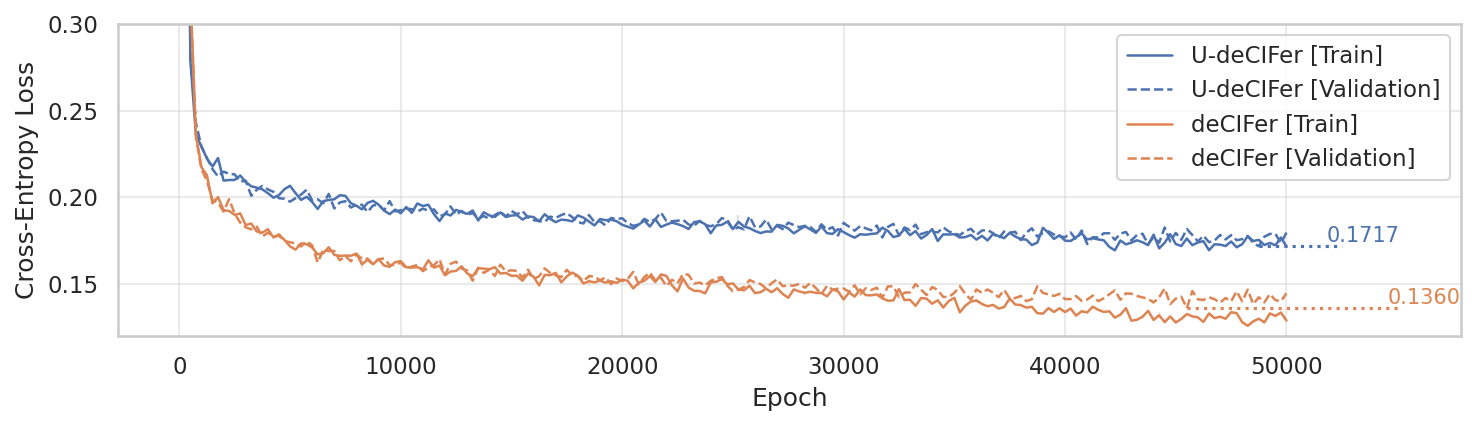

In [15]:
ckpts = [
    "../experiments/model__nocond__context_3076__robust_full_trainingcurves/ckpt.pt",
    "../experiments/model__conditioned_mlp_augmentation__context_3076__robust_full_trainingcurves/ckpt.pt"
]
custom_labels = [ "U-deCIFer", "deCIFer"]

plot_loss_curves(
    ckpts,
    ylog = False,
    xmax = None,
    ymin = 0.12,
    ymax = 0.3,
    figsize=(10,3),
    train_linewidth=1.2, 
    val_linewidth=1.2,
    custom_legend_labels=custom_labels,
    save_figure_path='loss_curves.pdf'
)